# TP RANDOM FOREST

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import scipy.stats as sps

In [2]:
dataset = pd.read_csv('mushrooms.csv',header=None)
dataset = dataset.sample(frac=1)

dataset

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
4812,p,f,f,y,f,f,f,c,b,p,...,k,n,b,p,w,o,l,h,y,g
1583,e,x,f,g,f,n,f,w,b,k,...,f,w,w,p,w,o,e,k,s,g
7843,e,x,s,g,f,n,f,w,b,w,...,s,w,w,p,w,t,p,w,s,g
5628,p,f,y,y,f,f,f,c,b,g,...,k,b,b,p,w,o,l,h,v,p
3984,p,x,y,y,f,f,f,c,b,p,...,k,n,n,p,w,o,l,h,v,p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,e,f,f,w,t,l,f,w,n,n,...,s,w,w,p,w,o,p,u,v,d
586,e,x,y,w,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,s,m
2043,e,x,f,n,f,n,f,w,b,k,...,f,w,w,p,w,o,e,n,s,g
1210,e,x,f,w,f,n,f,w,b,p,...,s,w,w,p,w,o,e,n,s,g


In [3]:
#on renomme les colonnes du dataset

dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor',
                   'gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape',
                       'stalk-root','stalk-surface-above-ring','stalk-surface-below-ring',
                           'stalk-color-above-ring','stalk-color-below-ring','veil-type',
                               'veil-color','ring-number','ring-type','spore-print-color',
                                   'population','habitat']

dataset

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4812,p,f,f,y,f,f,f,c,b,p,...,k,n,b,p,w,o,l,h,y,g
1583,e,x,f,g,f,n,f,w,b,k,...,f,w,w,p,w,o,e,k,s,g
7843,e,x,s,g,f,n,f,w,b,w,...,s,w,w,p,w,t,p,w,s,g
5628,p,f,y,y,f,f,f,c,b,g,...,k,b,b,p,w,o,l,h,v,p
3984,p,x,y,y,f,f,f,c,b,p,...,k,n,n,p,w,o,l,h,v,p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,e,f,f,w,t,l,f,w,n,n,...,s,w,w,p,w,o,p,u,v,d
586,e,x,y,w,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,s,m
2043,e,x,f,n,f,n,f,w,b,k,...,f,w,w,p,w,o,e,n,s,g
1210,e,x,f,w,f,n,f,w,b,p,...,s,w,w,p,w,o,e,n,s,g


In [4]:
#definition d'une fonction entropy qui calcule l'entropie d'une colonne

def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    
    return entropy
    

In [5]:
#entropy('target')
#entropy('cap-shape')
entropy('odor')

0.0

In [6]:
#definition d'une fonction InfoGain qui calcule le gain d'information de chaque attribut de la colonne target
def InfoGain(data,split_attribute_name,target_name="target"):
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])

    #Calculate the values and the corresponding counts for the split attribute
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)

    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(
        data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) 
                               for i in range(len(vals))])

    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy

    return Information_Gain




In [7]:

#definition d'une fonction ID3 qui  
def ID3(data,originaldata,features,target_attribute_name="target",parent_node_class = None):
    #Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    #If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]

    #If the feature space is empty, return the mode target feature value of the direct parent node --> Note that
    #the direct parent node is that node which has called the current run of the ID3 algorithm and hence
    #the mode target feature value is stored in the parent_node_class variable.
    elif len(features) ==0:
        return parent_node_class

    #If none of the above holds true, grow the tree!
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]

        #Implement the subspace sampling. Draw a number of m = sqrt(p) features
        features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)


        #Select the feature which best splits the dataset
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features]
        #Return the information gain values for the features in the dataset
        
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        tree = {best_feature:{}}

        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]

        #Grow a branch under the root node for each possible value of the root node feature
        for value in np.unique(data[best_feature]):
            value = value
            
            #Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()
            
            #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
            
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree
        
        return(tree)



In [8]:

def predict(query,tree,default = 'p'):
    
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result

In [9]:
#definition d'une fonction train_test_split qui prends en paramètre le jeu de données et le divise en deux parties(75% et 25%)
def train_test_split(dataset):
    training_data = dataset.iloc[:round(0.75*len(dataset))].reset_index(drop=True)
    #We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[round(0.75*len(dataset)):].reset_index(drop=True)
    
    return training_data,testing_data

training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]

In [10]:
#Train the Random Forest model
def RandomForest_Train(dataset,number_of_Trees):
    #Create a list in which the single forests are stored
    random_forest_sub_tree = []

    #Create a number of n models
    for i in range(number_of_Trees):
        #Create a number of bootstrap sampled datasets from the original dataset
        bootstrap_sample = dataset.sample(frac=1,replace=True)

        #Create a training and a testing datset by calling the train_test_split function
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1]

        #Grow a tree model for each of the training data

        #We implement the subspace sampling in the ID3 algorithm itself. Hence take a look at the ID3 algorithm above!
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,
                                          bootstrap_training_data.drop(labels=['target'],
                                                                       axis=1).columns))


    return random_forest_sub_tree

random_forest = RandomForest_Train(dataset,50)





/tmp/ipykernel_5104/3572939303.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)


In [11]:
#######Predict a new query instance###########
def RandomForest_Predict(query,random_forest,default='p'):
    predictions = []
    for tree in random_forest:
        predictions.append(predict(query,tree,default))
    return sps.mode(predictions)[0][0]


query = testing_data.iloc[0,:].drop('target').to_dict()

query_target = testing_data.iloc[0,0]

print('target: ',query_target)

prediction = RandomForest_Predict(query,random_forest)

print('prediction: ',prediction)

target:  e
prediction:  e


In [12]:
#######Test the model on the testing data and return the accuracy###########

def RandomForest_Test(data,random_forest):

    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest,default='p')
    
    accuracy = sum(data['predictions'] == data['target'])/len(data)*100
    print('The prediction accuracy is: ',sum(data['predictions']== data['target'])/len(data)*100,'%')
    return accuracy


RandomForest_Test(testing_data,random_forest)

The prediction accuracy is:  90.15263417035942 %


90.15263417035942

In /home/tsanga/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tsanga/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tsanga/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/tsanga/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/tsanga/anaconda3/lib/python3.9/site-packages/matplo

The prediction accuracy is:  98.12900049236829 %
The prediction accuracy is:  84.49039881831611 %
The prediction accuracy is:  82.7178729689808 %
The prediction accuracy is:  88.33087149187593 %
The prediction accuracy is:  82.7178729689808 %
The prediction accuracy is:  88.23239783357951 %
The prediction accuracy is:  90.10339734121122 %
The prediction accuracy is:  88.67552929591335 %
The prediction accuracy is:  95.42097488921713 %
The prediction accuracy is:  88.38010832102412 %
The prediction accuracy is:  88.87247661250616 %
The prediction accuracy is:  88.28163466272771 %
The prediction accuracy is:  88.97095027080256 %
The prediction accuracy is:  88.92171344165436 %
The prediction accuracy is:  90.39881831610043 %
The prediction accuracy is:  88.67552929591335 %
The prediction accuracy is:  90.10339734121122 %
The prediction accuracy is:  89.75873953717381 %
The prediction accuracy is:  90.20187099950763 %
The prediction accuracy is:  89.95568685376661 %
The prediction accurac

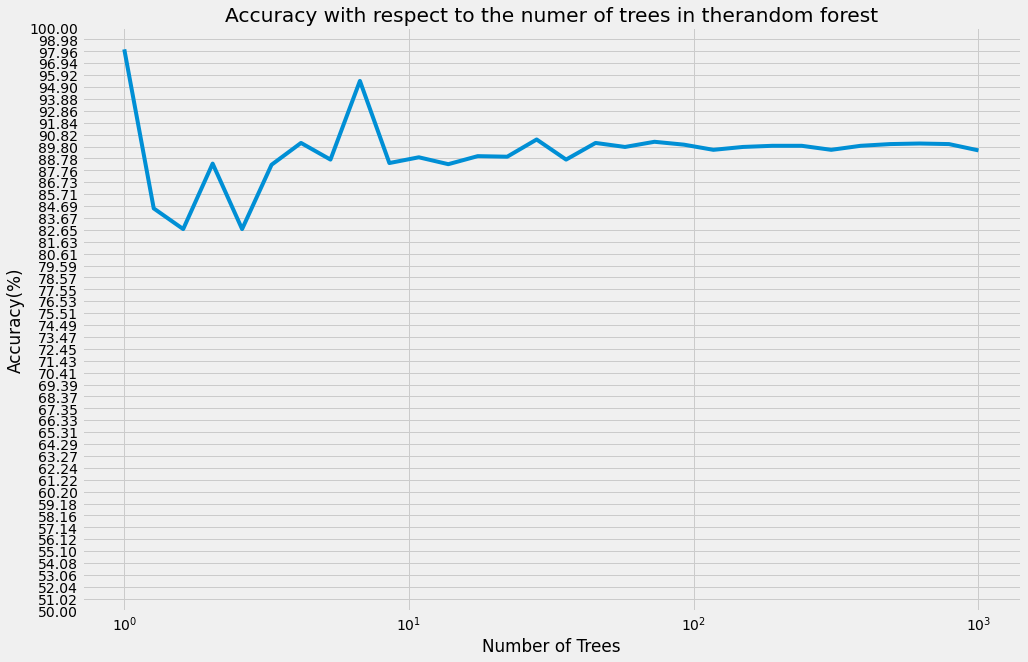

In [13]:
#Plot the prediction accuracy with respect to the numberof Trees in the random forests

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

fig = plt.figure(figsize=(15,10))

ax0 = fig.add_subplot(111)

accuracy = []

for i in range(1,11,1):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))

for i in range(10,110,10):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))

for i in range(100,1100,100):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))

print(accuracy)

ax0.plot(np.logspace(0,3,30),accuracy)

ax0.set_yticks(np.linspace(50,100,50))

ax0.set_title("Accuracy with respect to the numer of trees in therandom forest")

ax0.set_xscale('log')

ax0.set_xlabel("Number of Trees")

ax0.set_ylabel('Accuracy(%)')

plt.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

In [ ]:
#Encode the feature values which are strings to integers
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

X = dataset.drop(['target'],axis=1)
Y = dataset['target']

In [ ]:
#Instantiate the model with 100 trees and entropy as splitting criteria
Random_Forest_model = RandomForestClassifier(n_estimators=100,criterion="entropy")

#Cross validation
accuracy = cross_validate(Random_Forest_model,X,Y,cv=10)['test_score']

print('The accuracy is: ',sum(accuracy)/len(accuracy)*100,'%')

